In [1]:
!pip install mlxtend

In [2]:
#Importing libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.model_selection import KFold
from mlxtend.evaluate import bias_variance_decomp
from sklearn.linear_model import Ridge, RidgeCV
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler

#### Introduction

I did my project on the data science industry. Theres two parts of my project:

Part 1: Building a linear model to predict the salaries in the data science industry.

Part 2: EDA in the data science industry

In [3]:
#importing data sets for analysis
survey_responses = pd.read_csv("kaggle_survey_2022_responses.csv")
salaries = pd.read_csv("ds_salaries.csv")
country_codes = pd.read_csv("continents2.csv")

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,208,225,255,257,260,270,271,277) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
salaries = salaries[salaries['employment_type'] == 'FT']
salaries.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


Using salary_in_usd as my predictor variable as it puts all salaries on a level playing field, where as the salary column has it in different currencies and that would be a big factor in my model I did not want to include

I filtered out the employment_type column to only include full time employees as I wanted to focus on other features in my model to gain insights where its obvious that full timers make more than part timers.

In [5]:
country_codes.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


The alpha-2 column contains the same country codes as the employee_residence and company_location columns so I can merge them together easily

In [6]:
survey_responses.head()

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,...,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,"Are you currently a student? (high school, uni...",On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...
1,121,30-34,Man,India,No,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,462,30-34,Man,Algeria,No,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,293,18-21,Man,Egypt,Yes,Coursera,edX,NaN,DataCamp,NaN,...,NaN,"Kaggle (notebooks, forums, etc)",NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...","Podcasts (Chai Time Data Science, O’Reilly Dat...",NaN,NaN,NaN,NaN,NaN
4,851,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,NaN,"Kaggle (notebooks, forums, etc)","Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN


A difficult data frame to work with where the questions are the first row and each column contributes to a different choice in answer to the question, I'll have to rename the necessary columns and drop the first row

finding features to predict salaries

**Part 1**

I wanted to take a look at my predictor variable first. I noticed that there are some incredibly low salaries, especially since they are in Us Dollars, so I needed to investigate more.

<AxesSubplot:xlabel='salary_in_usd'>

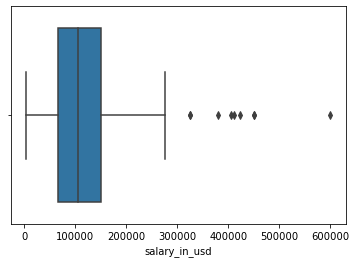

In [7]:
sns.boxplot(data=salaries, x = 'salary_in_usd')

In [8]:
salaries['salary_in_usd'].describe()

count       588.000000
mean     113468.073129
std       69476.470098
min        2859.000000
25%       64962.250000
50%      104196.500000
75%      150000.000000
max      600000.000000
Name: salary_in_usd, dtype: float64

In [9]:
salaries.sort_values('salary_in_usd').head(15)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
176,176,2021,MI,FT,Data Scientist,58000,MXN,2859,MX,0,MX,S
185,185,2021,MI,FT,Data Engineer,4000,USD,4000,IR,100,IR,M
238,238,2021,EN,FT,Data Scientist,4000,USD,4000,VN,0,VN,M
179,179,2021,MI,FT,Data Scientist,420000,INR,5679,IN,100,US,S
18,18,2020,EN,FT,Data Science Consultant,423000,INR,5707,IN,50,IN,M
213,213,2021,EN,FT,Big Data Engineer,435000,INR,5882,IN,0,CH,L
50,50,2020,EN,FT,Data Analyst,450000,INR,6072,IN,0,IN,S
21,21,2020,MI,FT,Product Data Analyst,450000,INR,6072,IN,100,IN,L
15,15,2020,MI,FT,Data Analyst,8000,USD,8000,PK,50,PK,L
196,196,2021,EN,FT,BI Data Analyst,9272,USD,9272,KE,100,KE,S


I noticed some trends among the lowest 15 salaries in usd, them veing the employee residence and experience level. I didn't drop them because these could be important features in the model that assoicate with low earning salaries and dropping these columns would be wasting valuable information 

All the possible predictor variables are categorical so I'll have to do lots of encoding. The first thing I wanted to look at were the job titles

In [10]:
print(salaries.shape)
print(salaries['job_title'].unique())
print(len(salaries['job_title'].unique()))

(588, 12)
['Data Scientist' 'Machine Learning Scientist' 'Big Data Engineer'
 'Product Data Analyst' 'Machine Learning Engineer' 'Data Analyst'
 'Lead Data Scientist' 'Business Data Analyst' 'Lead Data Engineer'
 'Lead Data Analyst' 'Data Engineer' 'Data Science Consultant'
 'BI Data Analyst' 'Director of Data Science' 'Research Scientist'
 'Machine Learning Manager' 'Data Engineering Manager'
 'Machine Learning Infrastructure Engineer' 'AI Scientist'
 'Principal Data Scientist' 'Data Science Manager' 'Head of Data'
 'Data Analytics Engineer' 'Applied Data Scientist'
 'Marketing Data Analyst' 'Cloud Data Engineer' 'Financial Data Analyst'
 'Computer Vision Software Engineer' 'Director of Data Engineering'
 'Data Science Engineer' 'Principal Data Engineer'
 'Machine Learning Developer' 'Applied Machine Learning Scientist'
 'Computer Vision Engineer' 'ML Engineer' 'Data Analytics Manager'
 'Head of Data Science' 'Data Specialist' 'Data Architect'
 'Finance Data Analyst' 'Principal Data A

Lots of job titles, if I include them all it will make the model too complex, a lot of them are simular so Im going to divide them into domains based on the data science industry.

I went with Data science, Data analyst, Data engineer and Machine Learning as my domains because I felt most of them would fit into one of those cateogires looking at the unique job titles and general domain knowledge

In [11]:
def domain_divider(data):
    data_copy = data.copy()
    #using regex to divide them into a domain each, I wanted to divide them based on key words in their job titles
    data_science_regex = re.compile(r'(Scientist|Science)')
    data_analyst_regex = re.compile(r'Analyst|Analytics')
    data_engineer_regex = re.compile(r'Engineer|Engineering')
    data_ML_regex = re.compile(r'Machine Learning|ML')
    data_copy['data_science_domain'] = [1 if bool(re.search(data_science_regex, x)) else 0 for x in data_copy['job_title']]
    data_copy['data_analyst_domain'] = [1 if bool(re.search(data_analyst_regex, x)) else 0 for x in data_copy['job_title']]
    data_copy['data_engineer_domain'] = [1 if bool(re.search(data_engineer_regex, x)) else 0 for x in data_copy['job_title']]
    data_copy['data_ML_domain'] = [1 if bool(re.search(data_ML_regex, x)) else 0 for x in data_copy['job_title']]
    return data_copy

salaries_with_domains = domain_divider(salaries)
salaries_with_domains.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,data_science_domain,data_analyst_domain,data_engineer_domain,data_ML_domain
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L,1,0,0,0
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S,1,0,0,1
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M,0,0,1,0
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S,0,1,0,0
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L,0,0,1,1


<AxesSubplot:xlabel='total_domains', ylabel='count'>

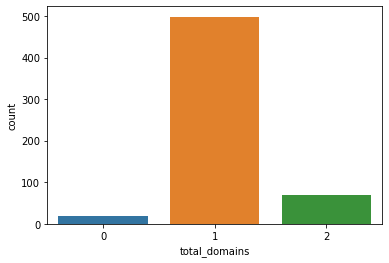

In [12]:
def total_domains(data):
    data_copy = data.copy()
    data_copy['total_domains'] = data_copy['data_science_domain'] + data_copy['data_analyst_domain'] + data_copy['data_engineer_domain'] + data_copy['data_ML_domain']
    return data_copy

salaries_with_total_domains = total_domains(salaries_with_domains)
sns.countplot(x='total_domains', data = salaries_with_total_domains)

Ideally I want every job title to fall into one domain only, because it would improve the model quality. This is because having an observation contributing to multiple domains would be inefficent because it would be more difficult to show the difference being in one domain then the other and an observation being in no domain means its not being counted at all when I include the domains in the model, which is not counting unseen information. However, for the most part they did fall into one domain and the ones to fall into 2 domains were hard to determine what domain it fell into and the job titles that fell into no domains, it was also hard to determine what domain they would fall into without creating extra features and making the model over complex.

In [13]:
salary_domains_md = salaries_with_total_domains[salaries_with_total_domains['total_domains'] == 2]
salary_domains_md['job_title'].unique()

array(['Machine Learning Scientist', 'Machine Learning Engineer',
       'Machine Learning Infrastructure Engineer',
       'Data Analytics Engineer', 'Data Science Engineer',
       'Applied Machine Learning Scientist', 'ML Engineer',
       'Analytics Engineer', 'Lead Machine Learning Engineer'],
      dtype=object)

In [14]:
salary_domains_nd = salaries_with_total_domains[salaries_with_total_domains['total_domains'] == 0]
salary_domains_nd['job_title'].unique()

array(['Head of Data', 'Data Specialist', 'Data Architect',
       'Big Data Architect', 'ETL Developer'], dtype=object)

Text(0.5, 1.0, 'Count of each domain')

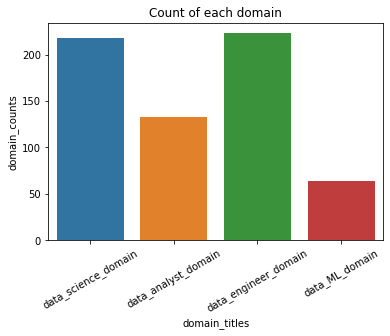

In [15]:
domain_counts = np.array([sum(salaries_with_total_domains['data_science_domain']), sum(salaries_with_total_domains['data_analyst_domain']), sum(salaries_with_total_domains['data_engineer_domain']), sum(salaries_with_total_domains['data_ML_domain'])])
domain_titles = np.array(['data_science_domain', 'data_analyst_domain', 'data_engineer_domain', 'data_ML_domain'])
domain_df = pd.DataFrame()
domain_df['domain_counts'] = domain_counts
domain_df['domain_titles'] = domain_titles
fig, ax = plt.subplots()
sns.barplot(x='domain_titles',y='domain_counts', data=domain_df)
props = {"rotation" : 30}
plt.setp(ax.get_xticklabels(), **props)
plt.title("Count of each domain")

(0.0, 625000.0)

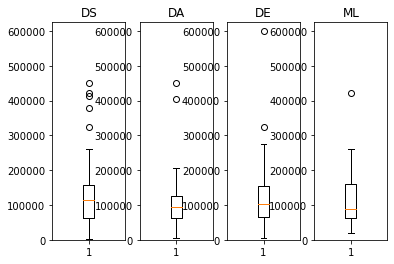

In [16]:
salary_ds = salaries_with_total_domains[salaries_with_total_domains['data_science_domain']==1]
salary_da = salaries_with_total_domains[salaries_with_total_domains['data_analyst_domain']==1]
salary_de = salaries_with_total_domains[salaries_with_total_domains['data_engineer_domain']==1]
salary_ml = salaries_with_total_domains[salaries_with_total_domains['data_ML_domain']==1]
fig, ax=plt.subplots(1,4)
#salary_domains_countries_merged_ds
ax[0].boxplot(data = salary_ds, x = 'salary_in_usd')
ax[0].set_title('DS')
ax[1].boxplot(data = salary_da, x = 'salary_in_usd')
ax[1].set_title('DA')
ax[2].boxplot(data = salary_de, x = 'salary_in_usd')
ax[2].set_title('DE')
ax[3].boxplot(data = salary_ml, x = 'salary_in_usd')
ax[3].set_title('ML')
ax[0].set_ylim(0,625000)
ax[1].set_ylim(0,625000)
ax[2].set_ylim(0,625000)
ax[3].set_ylim(0,625000)

In [17]:
print("data analyst")
print(salary_da['salary_in_usd'].describe())
print("data engineer")
print(salary_de['salary_in_usd'].describe())
print("data science")
print(salary_ds['salary_in_usd'].describe())
print("ml")
print(salary_ml['salary_in_usd'].describe())

data analyst
count       133.000000
mean      99508.481203
std       59565.794558
min        6072.000000
25%       61896.000000
50%       93700.000000
75%      126500.000000
max      450000.000000
Name: salary_in_usd, dtype: float64
data engineer
count       223.000000
mean     112022.663677
std       68873.228226
min        4000.000000
25%       65006.500000
50%      101570.000000
75%      154600.000000
max      600000.000000
Name: salary_in_usd, dtype: float64
data science
count       218.000000
mean     119744.880734
std       74200.723224
min        2859.000000
25%       62997.000000
50%      115000.000000
75%      158800.000000
max      450000.000000
Name: salary_in_usd, dtype: float64
ml
count        64.000000
mean     114936.500000
std       76261.824491
min       20000.000000
25%       63446.000000
50%       88293.000000
75%      161249.000000
max      423000.000000
Name: salary_in_usd, dtype: float64


I wanted to make sure their was enough of each domain to get accurate results in the model, given the count plot above, their was enough in each domain to include all 4 domains in my model

I also wanted to see if their was a difference among the domains to add them to my model. If there wasnt there would be no point in including them in my model since it would make my model complex for no reason. It seems like DS makes the most by a decent margin and data analyst makes the least, so if I wanted to make my model less complex when I get to the modeling part of my project I might drop DE and ML features

In [18]:
print(salaries['employee_residence'].unique())
print(len(salaries['employee_residence'].unique()))

['DE' 'JP' 'GB' 'HN' 'US' 'HU' 'NZ' 'FR' 'IN' 'PK' 'PL' 'PT' 'CN' 'GR'
 'AE' 'NL' 'MX' 'CA' 'AT' 'NG' 'PH' 'ES' 'DK' 'HR' 'IT' 'BG' 'SG' 'IQ'
 'VN' 'BR' 'BE' 'UA' 'RU' 'MT' 'CL' 'RO' 'IR' 'CO' 'MD' 'KE' 'SI' 'HK'
 'TR' 'RS' 'PR' 'LU' 'JE' 'CZ' 'AR' 'MY' 'EE' 'AU' 'BO' 'IE' 'CH']
55


I ran into the same problem as before for the employee residences, I had the country codes data set that could easily categorize the countries into regions and subregions for me

In [19]:
country_codes_regions_only = country_codes[['alpha-2', 'region', 'sub-region']]
country_codes_regions_only

,alpha-2,region,sub-region
0,AF,Asia,Southern Asia
1,AX,Europe,Northern Europe
2,AL,Europe,Southern Europe
3,DZ,Africa,Northern Africa
4,AS,Oceania,Polynesia
...,...,...,...
244,WF,Oceania,Polynesia
245,EH,Africa,Northern Africa
246,YE,Asia,Western Asia
247,ZM,Africa,Sub-Saharan Africa


In [20]:
salary_domains_countries_merged = salaries_with_total_domains.merge(country_codes_regions_only, 
                                                                    left_on = "employee_residence",
                                                                    right_on = "alpha-2",
                                                                   how='left')
#Merging the two together

region
Africa        3
Americas    369
Asia         57
Europe      155
Oceania       4
dtype: int64


[Text(0.5, 1.0, 'Countplot of regions where the observations are from')]

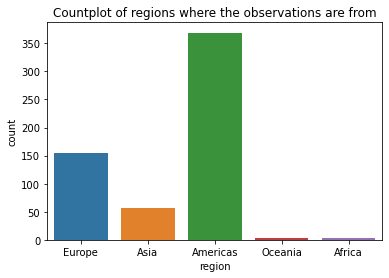

In [21]:
print(salary_domains_countries_merged.groupby('region').size())
sns.countplot(x='region', data = salary_domains_countries_merged).set(title = "Countplot of regions where the observations are from")

When seeing how many observations are in each region I noticed two issues.

1. There was a region called the Americas and I felt that was to broad for the insights I was looking for because theres a huge difference culturally from a tech perspective from North America and South America and I wanted to highlight that in my model.

2. There is very little observations in Africa and Oceania, so I will not be including them in my model since thier sample sizes are too small and would make the model less accurate

sub-region
Australia and New Zealand            4
Eastern Asia                         9
Eastern Europe                      15
Latin America and the Caribbean     13
Northern America                   356
Northern Europe                     48
South-eastern Asia                   7
Southern Asia                       34
Southern Europe                     40
Sub-Saharan Africa                   3
Western Asia                         7
Western Europe                      52
dtype: int64


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

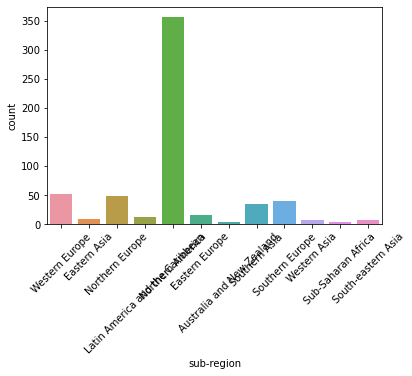

In [22]:
print(salary_domains_countries_merged.groupby('sub-region').size())
fig, ax = plt.subplots()
sns.countplot(x='sub-region', data = salary_domains_countries_merged)
props = {"rotation" : 45}
plt.setp(ax.get_xticklabels(), **props)

Finding the counts of the subregions of the observations, there was a lot of northern America features that I can include in my model, but not enough for Latin America and the caribbien.

So overall I will be including Europe, Asia and North America as my regions to include in my model

experience_level
EN     79
EX     25
MI    206
SE    278
dtype: int64


<AxesSubplot:xlabel='experience_level', ylabel='count'>

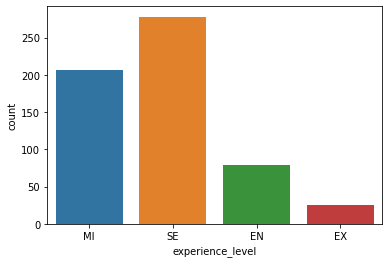

In [23]:
print(salary_domains_countries_merged.groupby('experience_level').size())
sns.countplot(x='experience_level', data = salary_domains_countries_merged)

I wanted to see if their was enough of a sample in each experience level for the model and there was.

In [24]:
def encoding_continents(data):
    data_copy = data.copy()
    data_copy['North_America'] = [1 if x == 'Northern America' else 0 for x in data_copy['sub-region']]
    data_copy['Asia'] = [1 if x == 'Asia' else 0 for x in data_copy['region']]
    data_copy['Europe'] = [1 if x == 'Europe' else 0 for x in data_copy['region']]
    return data_copy

def encoding_experience(data):
    data_copy = data.copy()
    data_copy['Entry_level'] = [1 if x == 'EN' else 0 for x in data_copy['experience_level']]
    data_copy['Junior_level'] = [1 if x == 'MI' else 0 for x in data_copy['experience_level']]
    data_copy['Senior_level'] = [1 if x == 'SE' else 0 for x in data_copy['experience_level']]
    data_copy['Expert_level'] = [1 if x == 'EX' else 0 for x in data_copy['experience_level']]
    return data_copy

In [25]:
salary_domains_countries_merged = encoding_continents(salary_domains_countries_merged)
salary_domains_countries_merged = encoding_experience(salary_domains_countries_merged)
salary_domains_countries_merged.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,...,alpha-2,region,sub-region,North_America,Asia,Europe,Entry_level,Junior_level,Senior_level,Expert_level
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,...,DE,Europe,Western Europe,0,0,1,0,1,0,0
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,...,JP,Asia,Eastern Asia,0,1,0,0,0,1,0
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,...,GB,Europe,Northern Europe,0,0,1,0,0,1,0
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,...,HN,Americas,Latin America and the Caribbean,0,0,0,0,1,0,0
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,...,US,Americas,Northern America,1,0,0,0,0,1,0


(0.0, 625000.0)

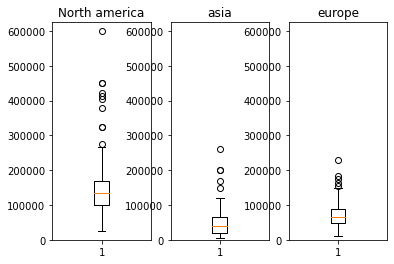

In [26]:
salary_domains_countries_merged_na = salary_domains_countries_merged[salary_domains_countries_merged['North_America']==1]
salary_domains_countries_merged_a = salary_domains_countries_merged[salary_domains_countries_merged['Asia']==1]
salary_domains_countries_merged_e = salary_domains_countries_merged[salary_domains_countries_merged['Europe']==1]
fig, ax=plt.subplots(1,3)
ax[0].boxplot(data = salary_domains_countries_merged_na, x = 'salary_in_usd')
ax[0].set_title('North america')
ax[1].boxplot(data = salary_domains_countries_merged_a, x = 'salary_in_usd')
ax[1].set_title('asia')
ax[2].boxplot(data = salary_domains_countries_merged_e, x = 'salary_in_usd')
ax[2].set_title('europe')
ax[0].set_ylim(0,625000)
ax[1].set_ylim(0,625000)
ax[2].set_ylim(0,625000)

In [27]:
print("North America")
print(salary_domains_countries_merged_na['salary_in_usd'].describe())
print("Asia")
print(salary_domains_countries_merged_a['salary_in_usd'].describe())
print("Europe")
print(salary_domains_countries_merged_e['salary_in_usd'].describe())

North America
count       356.000000
mean     144261.014045
std       66397.413329
min       25000.000000
25%      100600.000000
50%      135000.000000
75%      170000.000000
max      600000.000000
Name: salary_in_usd, dtype: float64
Asia
count        57.000000
mean      54385.228070
std       54745.792713
min        4000.000000
25%       18442.000000
50%       38400.000000
75%       66265.000000
max      260000.000000
Name: salary_in_usd, dtype: float64
Europe
count       155.000000
mean      71063.793548
std       34167.448097
min       10000.000000
25%       47590.500000
50%       65013.000000
75%       88293.000000
max      230000.000000
Name: salary_in_usd, dtype: float64


The boxplot and descriptions of each continent shows their is major difference between the 3 continents and their respective salaries in the data industry

[Text(0.5, 1.0, 'salary difference based on expeirence')]

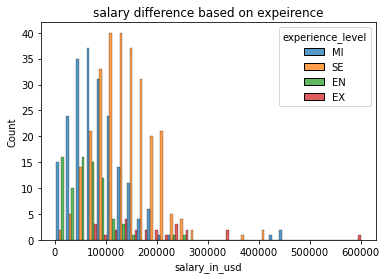

In [28]:
sns.histplot(data=salary_domains_countries_merged, x='salary_in_usd', hue='experience_level', multiple = 'dodge').set(title = "salary difference based on expeirence")

experience_level
EN     64457.455696
EX    190727.720000
MI     88403.169903
SE    139021.014388
Name: salary_in_usd, dtype: float64

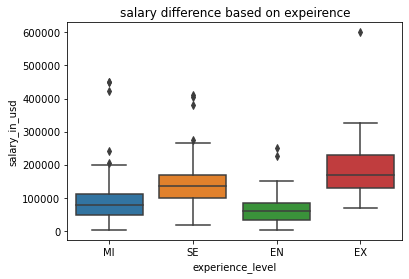

In [29]:
sns.boxplot(data=salary_domains_countries_merged, x='experience_level', y='salary_in_usd').set(title = "salary difference based on expeirence")
salary_domains_countries_merged.groupby('experience_level')['salary_in_usd'].agg('mean')

There is a major difference from the two lower expierence levels and the two high expeirence levels, if I need to make my model less complex I might just include the entry and expert levels and cut the middle two

work_year
2020     98542.661765
2021    100520.194175
2022    125194.796178
Name: salary_in_usd, dtype: float64
work_year
2020     68
2021    206
2022    314
dtype: int64


[Text(0.5, 1.0, 'Yearly salary difference in the data industry')]

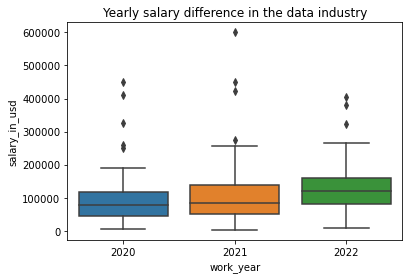

In [30]:
print(salary_domains_countries_merged.groupby('work_year')['salary_in_usd'].agg('mean'))
print(salary_domains_countries_merged.groupby('work_year').size())
sns.boxplot(data=salary_domains_countries_merged, x='work_year', y='salary_in_usd').set(title = "Yearly salary difference in the data industry")

In [31]:
def encoding_work_year(data):
    data_copy = data.copy()
    data_copy['2020'] = [1 if x == 2020 else 0 for x in data_copy['work_year']]
    data_copy['2021'] = [1 if x == 2021 else 0 for x in data_copy['work_year']]
    data_copy['2022'] = [1 if x == 2022 else 0 for x in data_copy['work_year']]
    return data_copy

salary_domains_countries_merged = encoding_work_year(salary_domains_countries_merged)

There is also a big salary difference between the work years, which is suprising because the years are so close together I didn't think it would make that big of a difference

company_size
L    119665.362694
M    118662.088050
S     76484.000000
Name: salary_in_usd, dtype: float64
company_size
L    193
M    318
S     77
dtype: int64


[Text(0.5, 1.0, 'salary difference based on company size')]

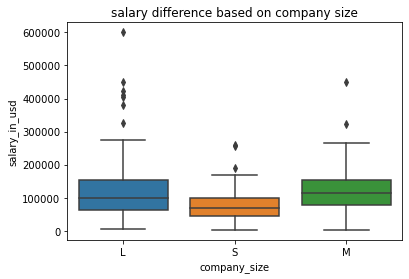

In [32]:
print(salaries.groupby('company_size')['salary_in_usd'].agg('mean'))
print(salaries.groupby('company_size').size())
sns.boxplot(data=salaries, x= 'company_size', y='salary_in_usd').set(title = "salary difference based on company size")

There's a big difference between working at a smaller company and one of the two larger companies, if the model needs to be less complex I might only include the small company feature.

In [33]:
def company_size(data):
    data_copy = data.copy()
    data_copy['large_company'] = [1 if x == 'L' else 0 for x in data_copy['company_size']]
    data_copy['Medium_company'] = [1 if x == 'M' else 0 for x in data_copy['company_size']]
    data_copy['Small_company'] = [1 if x == 'S' else 0 for x in data_copy['company_size']]
    return data_copy
salary_domains_countries_merged = company_size(salary_domains_countries_merged)
salary_domains_countries_merged

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,...,Entry_level,Junior_level,Senior_level,Expert_level,2020,2021,2022,large_company,Medium_company,Small_company
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,...,0,1,0,0,1,0,0,1,0,0
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,...,0,0,1,0,1,0,0,0,0,1
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,...,0,0,1,0,1,0,0,0,1,0
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,...,0,1,0,0,1,0,0,0,0,1
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,...,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,...,0,0,1,0,0,0,1,0,1,0
584,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,...,0,0,1,0,0,0,1,0,1,0
585,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,...,0,0,1,0,0,0,1,0,1,0
586,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,...,0,0,1,0,0,0,1,0,1,0


In [34]:
salary_domains_countries_merged.columns

Index(['Unnamed: 0', 'work_year', 'experience_level', 'employment_type',
       'job_title', 'salary', 'salary_currency', 'salary_in_usd',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size', 'data_science_domain', 'data_analyst_domain',
       'data_engineer_domain', 'data_ML_domain', 'total_domains', 'alpha-2',
       'region', 'sub-region', 'North_America', 'Asia', 'Europe',
       'Entry_level', 'Junior_level', 'Senior_level', 'Expert_level', '2020',
       '2021', '2022', 'large_company', 'Medium_company', 'Small_company'],
      dtype='object')

In [35]:
#choosing my predictors variables
predictors = salary_domains_countries_merged[['data_science_domain', 
                                              'data_analyst_domain',
                                             'data_engineer_domain',
                                             'data_ML_domain',
                                             'Entry_level',
                                             'Junior_level',
                                             'Senior_level',
                                             'Expert_level',
                                             'North_America',
                                             'Asia',
                                             'Europe',
                                             '2020',
                                             '2021',
                                             '2022',
                                             'Small_company',
                                             'Medium_company',
                                             'large_company']]
predictors.shape

(588, 17)

In [36]:
#selecting my response variable
response_variable = pd.Series(salary_domains_countries_merged['salary_in_usd'])

In [37]:
#spliting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors,
                                                    response_variable, test_size=0.2, random_state=1)

There's a lot of predictors and I fear it will make my model too complex. I want to find a way to select the ideal amount of predictors, so I used Sequential Feature Selector to choose the ideal amount of features based on r^2

In [38]:
#the sequential feature selector will use cross validation since Im using it in my model, its neccessary to include in my feature selector
cv = RepeatedKFold(n_splits=5, n_repeats = 1, random_state=1)

In [39]:
#setting the SFS parameters
sfs = SFS(LinearRegression(fit_intercept = True),
          k_features = 17,
          scoring = 'r2',
          cv= cv)

In [40]:
#fitting it to the predictors and response variable
sfs.fit(predictors, response_variable)

SequentialFeatureSelector(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=1),
                          estimator=LinearRegression(), k_features=(17, 17),
                          scoring='r2')

Text(0.5, 1.0, 'The Coefficent of Determination of each Feature')

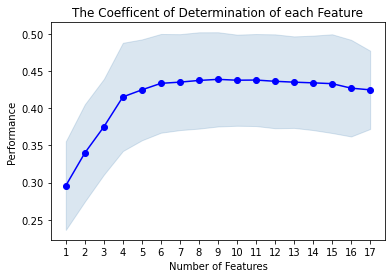

In [41]:
plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title("The Coefficent of Determination of each Feature")

Using the SFS plot I found that any amount of features less than 6 will make the model underfit and any features beyond 9 would make the model overfit because I want to have the best r^2 score with less features and 6-17 features gives the same r^2 so I determined that the ideal amount of features is 6-9

In [42]:
#setting up my linear model
linear_model = LinearRegression(fit_intercept = True)

In [43]:
#selecting the ideal columns for my model
def select_columns(data, *columns):
    return data.loc[:, columns]

def select_features(data):
    data_copy = data.copy()
    data_copy = select_columns(data_copy,
                               'data_science_domain', 
                                             'data_analyst_domain',
                                             #'data_engineer_domain',
                                             #'data_ML_domain',
                                             #'Entry_level',
                                             #'Junior_level',
                                             'Senior_level',
                                             'Expert_level',
                                             'North_America',
                                             #'Asia',
                                             'Europe',
                                             #'2020',
                                             #'2021',
                                             #'2022',
                                             'Small_company',
                                             #'Medium_company',
                                             #'large_company'
                              )
    return data_copy

def cross_validate_rmse(model, X_train, y_train):
    kf = KFold(n_splits=5)#using Kfold to split the test data into 5 chunks I choose 5 because I wanted the most amount of chunks with enough of a sample in each of them to give an accurate validation RMSE
    valid_rmse = [] #I used arrays to keep track of the results in each validation set
    avg_loss = []
    avg_bias = []
    avg_var = []
    for ti, vi in kf.split(X_train):
        split_X_train, split_X_valid = X_train.iloc[ti], X_train.iloc[vi] #setting the training and validation sets for each iteration
        split_y_train, split_y_valid = y_train.iloc[ti], y_train.iloc[vi] 
        model.fit(split_X_train, split_y_train) #fitting the training set
        y_predicted_valid = model.predict(split_X_valid) #predicting using the test set
        valid_error = np.sqrt((y_predicted_valid - split_y_valid)**2) #finding the RMSE of the validation error
        valid_rmse.append(valid_error)
        loss, bias, var = bias_variance_decomp(model, split_X_train.values, split_y_train.values, 
                                                split_X_valid.values, split_y_valid.values, loss='mse',
                                                num_rounds=100, random_seed=1) #using mlxtend bvd to keep track of the bias variance and loss in each iteration
        avg_loss.append(loss)
        avg_bias.append(bias)
        avg_var.append(var)
    return np.mean(valid_rmse), np.mean(avg_loss), np.mean(avg_bias), np.mean(avg_var), model

I decided to use cross validation, since you can't see how the test data is doing on the model until the very end because that would be fitting to "unseen data". I wanted a way to see my model performance on unseen data and using cross validation is perfect for that. I wanted to see the bias and variance of the model to compare to the Ridge regression model which I will use after I complete my linear model

In [62]:
X_cv_train = select_features(X_train)
rmse_valid, avg_loss, avg_bias, avg_var, model_l = cross_validate_rmse(linear_model, X_cv_train, y_train)
print(f'Average validation rmse: {rmse_valid}')
X_cv_test = select_features(X_test)
y_linear_train_pred = model_l.predict(X_cv_train)
print(f'Overall Train RMSE: {np.mean(np.sqrt((y_linear_train_pred - y_train)**2))}')
y_linear_pred = model_l.predict(X_cv_test)
print(f'Test RMSE: {np.mean(np.sqrt((y_linear_pred - y_test)**2))}')#THE TEST RMSE I DID NOT SHOW UNTIL I WAS SATISFIED WITH MY TRAINING RMSE
print(f'loss: {avg_loss}')
print(f'bias: {avg_bias}')
print(f'var: {avg_var}')
print(f'Columns used: {X_cv_train.columns}')
print(f'Coefficents: {model_l.coef_}')
print(f'Intercept: {model_l.intercept_}')

Average validation rmse: 34885.95843971372
Overall Train RMSE: 34653.49211238049
Test RMSE: 37186.9347598131
loss: 2764638750.859317
bias: 2690320782.2297997
var: 74317968.62951799
Columns used: Index(['data_science_domain', 'data_analyst_domain', 'Senior_level',
       'Expert_level', 'North_America', 'Europe', 'Small_company'],
      dtype='object')
Coefficents: [ 17312.53716333 -38128.29176348  38319.96921516 101637.94260591
  73286.39108114  15954.54685936 -17289.75729449]
Intercept: 45588.61812790433


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


For my linear model I started with all 17 features and looked at what coeffiecents had a slope closest to 0 to determine the least effective features and drop them from the model as they were making the model overcomplex, I kept decreasing my RMSE until I got to 7 features, not all coefficents were the furthest from 0 but this resulted in the lowest validation RMSE.

Test RMSE: 37186.9347598131


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


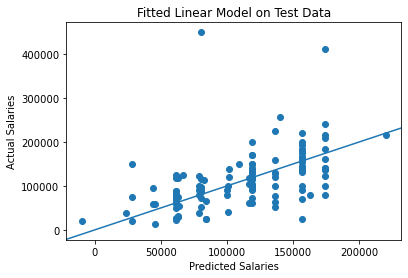

In [45]:
final_pred = model_l.predict(X_cv_test)
fig, ax = plt.subplots()
plt.scatter(final_pred, y_test)
ax.axline((0, 0), slope=1)
plt.ylabel("Actual Salaries")
plt.xlabel("Predicted Salaries")
plt.title("Fitted Linear Model on Test Data")
print(f'Test RMSE: {np.mean(np.sqrt((y_test - final_pred)**2))}')

I made a plot with predicted salaries on x-axis and actual salaries on the y-axis and also plotted a y=x line which is where if the model had 100% test accuracy every point should have fell on that line. In general outside of a few major outliers the model fit the test data pretty well with the exception of 2 major outliers and a salary predicted to be below 0. Another thing I noticed with this plot is that a lot of the x-axis points are the exact same I concluded that this was because all my features were 1 or 0's and that there was only so many possibilties for where the predicted salaries based on that.

In [46]:
model_ridge_cv = RidgeCV(alphas=np.arange(-10,10,0.1), cv=cv, scoring='neg_mean_absolute_error', fit_intercept = True) #setting up my ridge parameters, set scoring to MAE because there was no option for MSE so I had to use a different loss fucntion
scalar = StandardScaler()
scaled_predictors = scalar.fit_transform(X_cv_train)
model_ridge_cv.fit(scaled_predictors, y_train)
print(f'alpha: {model_ridge_cv.alpha_}')

alpha: 2.099999999999957


I used Ridge regression because there was alot of bias in my other model and ridge regression adds a parameter to have less bias and overfit the data less.

I first wanted to find my alpha parameter for ridge regression, so I iterated between all possibilites from -10 to 10 to find the ideal alpha and got 2.1 as my alpha

In [48]:
scaled_test = scalar.fit_transform(X_cv_test)
y_ridge_train = model_ridge_cv.predict(scaled_predictors)
y_ridge_preds = model_ridge_cv.predict(scaled_test)
print(f'Training RMSE: {np.mean(np.sqrt((y_train - y_ridge_train)**2))}')
print(f'Testing RMSE: {np.mean(np.sqrt((y_test - y_ridge_preds)**2))}')
loss, bias, var = bias_variance_decomp(model_ridge_cv, scaled_predictors, y_train.values, 
                                                scaled_test, y_test.values, loss='mse',
                                                num_rounds=100, random_seed=1)
print(f'Loss: {loss}')
print(f'Bias: {bias}')
print(f'Var: {var}')

Training RMSE: 33867.2422049952
Testing RMSE: 36743.83476517251
Loss: 3402831988.676518
Bias: 3348538313.3848505
Var: 54293675.291668


Using Ridge regression I found that I got a lower training RMSE than the linear model and the bias increased, but the variance decreased dramatically, this is because of the bias variance tradeoff.

Text(0, 0.5, 'Actual salaries')

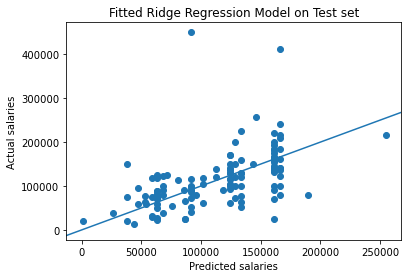

In [63]:
fig, ax = plt.subplots()
plt.scatter(x = y_ridge_preds, y = y_test)
ax.axline((0, 0), slope=1)

plt.title("Fitted Ridge Regression Model on Test set")
plt.xlabel("Predicted salaries")
plt.ylabel("Actual salaries")

I made a plot similar to the one I did with the Linear regression test data and found its slightly better because overall the points fall closer to the line and it doesnt predict any salaries being less than 0 and because of the hyperparameter lambda the points feel more scatter and less ooints on the same x-axis value (even though it still occurs)

#### PART 2: EDA on programming languages

I first needed the narrows down my data frame based on only the programming languages questions and rename their columns

In [50]:
Languages = survey_responses[['Q12_1',
                       'Q12_2',
                       'Q12_3',
                       'Q12_4',
                       'Q12_5',
                       'Q12_6',
                       'Q12_7',
                       'Q12_8',
                       'Q12_9',
                       'Q12_10',
                       'Q12_11',
                       'Q12_12']]
Languages = Languages.rename(columns={"Q12_1":'Python',
                          "Q12_2":"R",
                          "Q12_3":"SQL",
                          "Q12_4":"C",
                          "Q12_5":"C#",
                          "Q12_6":"C++",
                          "Q12_7":"Java",
                          "Q12_8":"Javascript",
                          "Q12_9":"Bash",
                          "Q12_10":"PHP",
                          "Q12_11":"MATLAB",
                          "Q12_12":"Julia",})

In [51]:
Languages_adjusted = Languages.iloc[3:]#the first row is the actual questions and the 2nd and 3rd row were both all null
Languages_adjusted

,Python,R,SQL,C,C#,C++,Java,Javascript,Bash,PHP,MATLAB,Julia
3,Python,NaN,SQL,C,NaN,NaN,NaN,NaN,NaN,NaN,MATLAB,NaN
4,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,Bash,NaN,NaN,NaN
5,Python,NaN,NaN,NaN,NaN,C++,Java,NaN,NaN,NaN,NaN,NaN
6,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Python,NaN,SQL,NaN,NaN,C++,NaN,Javascript,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23993,Python,R,SQL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23994,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23995,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23996,Python,R,NaN,NaN,NaN,NaN,NaN,NaN,Bash,NaN,NaN,NaN


I needed to find a way to get a percentage of how much each language was used, because with this dataframe I cant see how much each is being used

In [52]:
Languages_adjusted_percentages = pd.DataFrame((Languages_adjusted.count()/23995)*100)#creating percentage of usage
Languages_adjusted_percentages = Languages_adjusted_percentages.reset_index()
Languages_adjusted_percentages = Languages_adjusted_percentages.rename(columns={"index":"Language",
                                                                                0:"percentage"})
Languages_adjusted_percentages = Languages_adjusted_percentages.sort_values('percentage', ascending = False)
Languages_adjusted_percentages

,Language,percentage
0,Python,77.737029
2,SQL,40.091686
1,R,19.049802
5,C++,18.958116
6,Java,16.090852
3,C,15.840800
7,Javascript,14.540529
10,MATLAB,10.172953
8,Bash,6.976453
4,C#,6.138779


Text(0.5, 1.0, 'What Programming Langauges Are Used in the Data Industry')

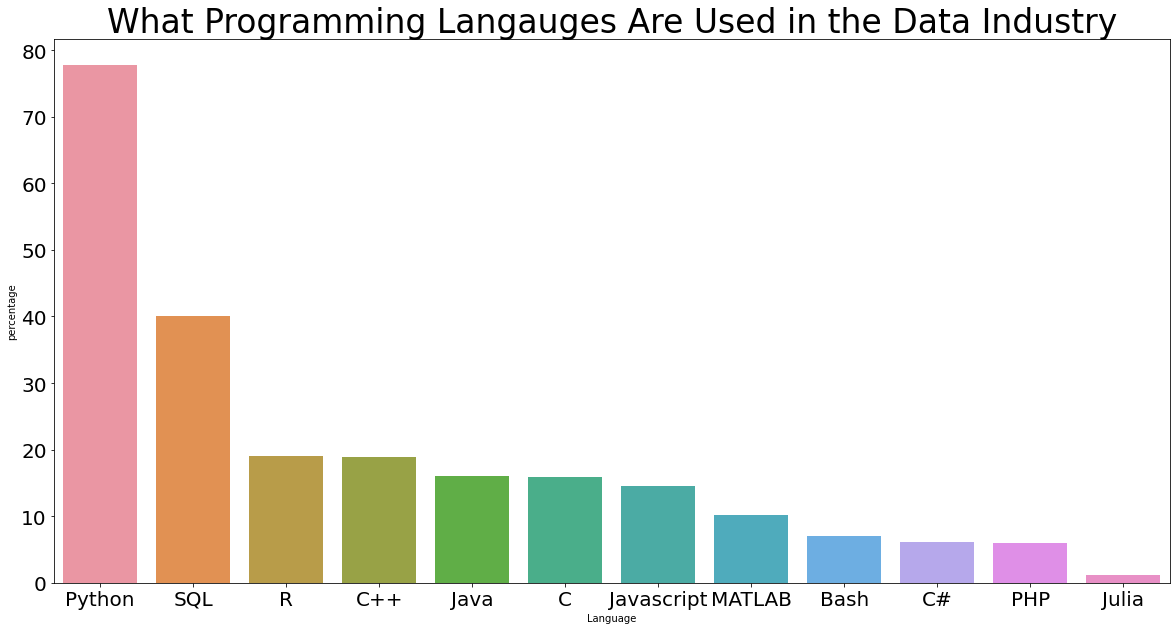

In [53]:
fig, ax = plt.subplots(figsize=(20, 10)) 
sns.barplot(data = Languages_adjusted_percentages,
            x = 'Language',
            y = 'percentage',
           ax=ax)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("What Programming Langauges Are Used in the Data Industry", fontsize=33)

It appears that Python is the most used by far, but there is some languages that were used more than I thought like C and Java, Im going to do more digging to see if I can find more trends on how the languages are used. I am going to see if the language used varies by job title

In [54]:
survey_responses['Q23'].unique()

array(['Select the title most similar to your current role (or most recent title if retired): - Selected Choice',
       nan, 'Data Scientist', 'Software Engineer', 'Research Scientist',
       'Other', 'Developer Advocate',
       'Data Analyst (Business, Marketing, Financial, Quantitative, etc)',
       'Data Engineer', 'Currently not employed',
       'Machine Learning/ MLops Engineer', 'Engineer (non-software)',
       'Teacher / professor', 'Statistician',
       'Manager (Program, Project, Operations, Executive-level, etc)',
       'Data Administrator', 'Data Architect'], dtype=object)

There seems to be a small amount of job titles compared to the other data set so I could try and use all of them

In [55]:
Positions = survey_responses[['Q23']] ## creating a data frame of just the job titles
print(Languages.shape)
print(Positions.shape)
languages_positions_merged = pd.merge(Languages, Positions, left_index = True, right_index = True) #merging the job titles and the languages together
languages_positions_merged_cleaned = languages_positions_merged.iloc[3:]#removing first 3 rows for the same reasons as earlier
languages_positions_merged_cleaned = languages_positions_merged_cleaned.dropna(subset = ['Q23'])#dropping no titled jobs
languages_positions_merged_cleaned_grouped = languages_positions_merged_cleaned.groupby(['Q23'])['Python',
                                                   'R',
                                                   'SQL',
                                                   'C++',
                                                   'Java',
                                                   'C',
                                                   'Javascript',
                                                   'MATLAB',
                                                   'Bash',
                                                   'C#',
                                                   'PHP',
                                                   'Julia'].count()#grouping by the languages to see the amount of times used per language
languages_positions_merged_cleaned_grouped = languages_positions_merged_cleaned_grouped.T #transposing so I can get the languages as a the rows and titles as the columns
languages_positions_merged_cleaned_grouped

(23998, 12)
(23998, 1)


/tmp/ipykernel_271/1641753167.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  languages_positions_merged_cleaned_grouped = languages_positions_merged_cleaned.groupby(['Q23'])['Python',


Q23,Currently not employed,Data Administrator,"Data Analyst (Business, Marketing, Financial, Quantitative, etc)",Data Architect,Data Engineer,Data Scientist,Developer Advocate,Engineer (non-software),Machine Learning/ MLops Engineer,"Manager (Program, Project, Operations, Executive-level, etc)",Other,Research Scientist,Software Engineer,Statistician,Teacher / professor
Python,1025,40,1138,82,316,1808,48,314,556,602,445,495,784,78,632
R,210,15,369,15,55,530,9,51,60,188,118,172,73,67,223
SQL,486,39,895,69,257,1140,26,124,227,379,241,129,526,47,246
C++,133,4,108,13,53,148,13,49,113,98,55,129,240,13,228
Java,116,7,90,30,66,183,21,32,80,109,61,62,307,5,173
C,129,5,82,12,41,126,11,38,61,91,51,104,178,9,239
Javascript,141,11,136,27,66,187,22,35,94,138,77,62,387,7,133
MATLAB,85,1,79,5,22,140,3,66,52,40,30,137,50,12,194
Bash,47,5,62,18,82,248,10,24,146,80,48,93,142,5,43
C#,42,9,49,23,35,87,9,10,35,65,32,42,201,7,62


In [56]:
size_of_positions = pd.DataFrame(languages_positions_merged_cleaned.groupby(['Q23']).size())#want to see how much of each job title is there
size_of_positions = size_of_positions.T
size_of_positions

Q23,Currently not employed,Data Administrator,"Data Analyst (Business, Marketing, Financial, Quantitative, etc)",Data Architect,Data Engineer,Data Scientist,Developer Advocate,Engineer (non-software),Machine Learning/ MLops Engineer,"Manager (Program, Project, Operations, Executive-level, etc)",Other,Research Scientist,Software Engineer,Statistician,Teacher / professor
0,1432,70,1538,95,352,1929,61,465,571,832,754,593,980,125,833


I wanted to get a percantage of each language used per title since there is larger sample sizes for different jobs and it would put all jobs on the same playing field

In [57]:
#hard coded each percentage
languages_positions_merged_cleaned_grouped_copy = languages_positions_merged_cleaned_grouped.copy()
languages_positions_merged_cleaned_grouped_copy['Currently not employed'] = languages_positions_merged_cleaned_grouped['Currently not employed']/size_of_positions['Currently not employed'].loc[0]
languages_positions_merged_cleaned_grouped_copy['Data Administrator'] = languages_positions_merged_cleaned_grouped['Data Administrator']/size_of_positions['Data Administrator'].loc[0]
languages_positions_merged_cleaned_grouped_copy['Data Analyst (Business, Marketing, Financial, Quantitative, etc)'] = languages_positions_merged_cleaned_grouped['Data Analyst (Business, Marketing, Financial, Quantitative, etc)']/size_of_positions['Data Analyst (Business, Marketing, Financial, Quantitative, etc)'].loc[0]
languages_positions_merged_cleaned_grouped_copy['Data Architect'] = languages_positions_merged_cleaned_grouped['Data Architect']/size_of_positions['Data Architect'].loc[0]
languages_positions_merged_cleaned_grouped_copy['Data Engineer'] = languages_positions_merged_cleaned_grouped['Data Engineer']/size_of_positions['Data Engineer'].loc[0]
languages_positions_merged_cleaned_grouped_copy['Data Scientist'] = languages_positions_merged_cleaned_grouped['Data Scientist']/size_of_positions['Data Scientist'].loc[0]
languages_positions_merged_cleaned_grouped_copy['Developer Advocate'] = languages_positions_merged_cleaned_grouped['Developer Advocate']/size_of_positions['Developer Advocate'].loc[0]
languages_positions_merged_cleaned_grouped_copy['Engineer (non-software)'] = languages_positions_merged_cleaned_grouped['Engineer (non-software)']/size_of_positions['Engineer (non-software)'].loc[0]
languages_positions_merged_cleaned_grouped_copy['Machine Learning/ MLops Engineer'] = languages_positions_merged_cleaned_grouped['Machine Learning/ MLops Engineer']/size_of_positions['Machine Learning/ MLops Engineer'].loc[0]
languages_positions_merged_cleaned_grouped_copy['Manager (Program, Project, Operations, Executive-level, etc)'] = languages_positions_merged_cleaned_grouped['Manager (Program, Project, Operations, Executive-level, etc)']/size_of_positions['Manager (Program, Project, Operations, Executive-level, etc)'].loc[0]
languages_positions_merged_cleaned_grouped_copy['Research Scientist'] = languages_positions_merged_cleaned_grouped['Research Scientist']/size_of_positions['Research Scientist'].loc[0]
languages_positions_merged_cleaned_grouped_copy['Software Engineer'] = languages_positions_merged_cleaned_grouped['Software Engineer']/size_of_positions['Software Engineer'].loc[0]
languages_positions_merged_cleaned_grouped_copy['Statistician'] = languages_positions_merged_cleaned_grouped['Statistician']/size_of_positions['Statistician'].loc[0]
languages_positions_merged_cleaned_grouped_copy['Teacher / professor'] = languages_positions_merged_cleaned_grouped['Teacher / professor']/size_of_positions['Teacher / professor'].loc[0]
languages_positions_merged_cleaned_grouped_copy['Other'] = languages_positions_merged_cleaned_grouped['Other']/size_of_positions['Other'].loc[0]
languages_positions_merged_cleaned_grouped_copy

Q23,Currently not employed,Data Administrator,"Data Analyst (Business, Marketing, Financial, Quantitative, etc)",Data Architect,Data Engineer,Data Scientist,Developer Advocate,Engineer (non-software),Machine Learning/ MLops Engineer,"Manager (Program, Project, Operations, Executive-level, etc)",Other,Research Scientist,Software Engineer,Statistician,Teacher / professor
Python,0.715782,0.571429,0.739922,0.863158,0.897727,0.937273,0.786885,0.675269,0.973730,0.723558,0.590186,0.834739,0.800000,0.624,0.758703
R,0.146648,0.214286,0.239922,0.157895,0.156250,0.274754,0.147541,0.109677,0.105079,0.225962,0.156499,0.290051,0.074490,0.536,0.267707
SQL,0.339385,0.557143,0.581925,0.726316,0.730114,0.590980,0.426230,0.266667,0.397548,0.455529,0.319629,0.217538,0.536735,0.376,0.295318
C++,0.092877,0.057143,0.070221,0.136842,0.150568,0.076724,0.213115,0.105376,0.197898,0.117788,0.072944,0.217538,0.244898,0.104,0.273709
Java,0.081006,0.100000,0.058518,0.315789,0.187500,0.094868,0.344262,0.068817,0.140105,0.131010,0.080902,0.104553,0.313265,0.040,0.207683
C,0.090084,0.071429,0.053316,0.126316,0.116477,0.065319,0.180328,0.081720,0.106830,0.109375,0.067639,0.175379,0.181633,0.072,0.286915
Javascript,0.098464,0.157143,0.088427,0.284211,0.187500,0.096941,0.360656,0.075269,0.164623,0.165865,0.102122,0.104553,0.394898,0.056,0.159664
MATLAB,0.059358,0.014286,0.051365,0.052632,0.062500,0.072576,0.049180,0.141935,0.091068,0.048077,0.039788,0.231029,0.051020,0.096,0.232893
Bash,0.032821,0.071429,0.040312,0.189474,0.232955,0.128564,0.163934,0.051613,0.255692,0.096154,0.063660,0.156830,0.144898,0.040,0.051621
C#,0.029330,0.128571,0.031860,0.242105,0.099432,0.045101,0.147541,0.021505,0.061296,0.078125,0.042440,0.070826,0.205102,0.056,0.074430


Felt there was too much information to graph so I needed to narrow down the jobs to the ones I felt were important and had the biggest difference, I decided to go with the same jobs I did in part 1 when dividing the domains

In [58]:
def select_positons(data):
    data_copy = data.copy()
    data_copy = select_columns(data_copy,
                               'Data Scientist',
                               'Data Engineer',
                               'Data Analyst (Business, Marketing, Financial, Quantitative, etc)',
                               'Machine Learning/ MLops Engineer')#selecting the columns of jobs I want
    return data_copy
languages_positions_merged_cleaned_grouped_copy_selected = select_positons(languages_positions_merged_cleaned_grouped_copy)
languages_positions_merged_cleaned_grouped_copy_selected

Q23,Data Scientist,Data Engineer,"Data Analyst (Business, Marketing, Financial, Quantitative, etc)",Machine Learning/ MLops Engineer
Python,0.937273,0.897727,0.739922,0.973730
R,0.274754,0.156250,0.239922,0.105079
SQL,0.590980,0.730114,0.581925,0.397548
C++,0.076724,0.150568,0.070221,0.197898
Java,0.094868,0.187500,0.058518,0.140105
C,0.065319,0.116477,0.053316,0.106830
Javascript,0.096941,0.187500,0.088427,0.164623
MATLAB,0.072576,0.062500,0.051365,0.091068
Bash,0.128564,0.232955,0.040312,0.255692
C#,0.045101,0.099432,0.031860,0.061296


In [59]:
languages_positions_merged_cleaned_grouped_copy_selected = languages_positions_merged_cleaned_grouped_copy_selected.rename(columns={
    'Data Analyst (Business, Marketing, Financial, Quantitative, etc)':'Data Analyst',
    'Machine Learning/ MLops Engineer' : 'Machine Learning'})#renaming columns to make legen easier to read

Text(0, 0.5, 'Percentage used')

<Figure size 320x8000 with 0 Axes>

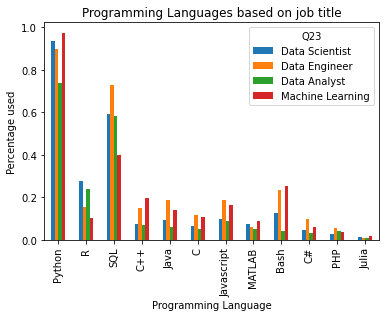

In [60]:
figure(figsize=(4, 100), dpi=80)
languages_positions_merged_cleaned_grouped_copy_selected[languages_positions_merged_cleaned_grouped_copy_selected.columns].plot(kind='bar')#had to make the columns the hue and the indices the x-axis
plt.title("Programming Languages based on job title")
plt.xlabel("Programming Language")
plt.ylabel("Percentage used")

Based on the bar plot above I found that languages like Java, C and Bash were used more by the Data engineers and people who worked in Machine learning rather than the data scientist and data analysts